Optimal Transport with Linear Programming
=========================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Optimal Transport of Discrete Distribution
------------------------------------------
We consider two dicretes distributions
$$ \forall k=0,1, \quad \mu_k = \sum_{i=1}^{n_k} p_{k,i} \de_{x_{k,i}} $$
where $n_0,n_1$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $ X_k = ( x_{k,i} )_{i=1}^{n_k} \subset \RR^d$ for $k=0,1$
are two point clouds.


We define the set of couplings between $\mu_0,\mu_1$ as

$$ \Pp = \enscond{ (\ga_{i,j})_{i,j} \in (\RR^+)^{n_0 \times n_1} }{
     \forall i, \sum_j \ga_{i,j} = p_{0,i}, \:
     \forall j, \sum_i \ga_{i,j} = p_{1,j} } $$


The Kantorovitch formulation of the optimal transport reads

$$ \ga^\star \in \uargmin{\ga \in \Pp} \sum_{i,j} \ga_{i,j} C_{i,j}  $$
where $C_{i,j} \geq 0$ is the cost of moving some mass from $x_{0,i}$
to $x_{1,j}$.


The optimal coupling $\ga^\star$ can be shown to be a sparse matrix
with less than $n_0+n_1-1$ non zero entries. An entry $\ga_{i,j}^\star \neq 0$
should be understood as a link between $x_{0,i}$
and $x_{1,j}$ where an amount of mass equal to $\ga_{i,j}^\star$ is transfered.


In the following, we concentrate on the $L^2$ Wasserstein distance.
$$ C_{i,j}=\norm{x_{0,i}-x_{1,j}}^2. $$


The $L^2$ Wasserstein distance is then defined as
$$ W_2(\mu_0,\mu_1)^2 = \sum_{i,j} \ga_{i,j}^\star C_{i,j}. $$


The coupling constraint
$$
     \forall i, \sum_j \ga_{i,j} = p_{0,i}, \:
     \forall j, \sum_i \ga_{i,j} = p_{1,j}
$$
can be expressed in matrix form as
$$ \Sigma(n_0,n_1) \ga = [p_0;p_1] $$
where $ \Sigma(n_0,n_1) \in \RR^{ (n_0+n_1) \times (n_0 n_1) } $.

In [2]:
from scipy import sparse

Rows  = lambda n0,n1: sparse.coo_matrix((np.ones(n0*n1), 
                                         (np.ravel(np.tile(np.arange(0,n0),(n1,1)),order='C'),
                                          np.arange(0,n0*n1))))
Cols  = lambda n0,n1: sparse.coo_matrix((np.ones(n0*n1), 
                                        (np.ravel(np.tile(np.arange(0,n1),(n0,1)),order='F'),
                                         np.arange(0,n0*n1))))
Sigma = lambda n0,n1: sparse.vstack((Rows(n0,n1),Cols(n0,n1)))

In [3]:
# plot the constraint matrix.

We use a simplex algorithm to compute the optimal transport coupling
$\ga^\star$.

In [4]:
from nt_toolbox.perform_linprog import *
maxit = 1e4
tol = 1e-9
otransp = lambda C,p0,p1: np.reshape(perform_linprog(Sigma(len(p0),len(p1)).toarray(),np.vstack((p0,p1)),C,maxit,tol),(n0,n1),order="F")

Dimensions $n_0, n_1$ of the clouds.

In [5]:
n0 = 60
n1 = 80

Compute a first point cloud $X_0$ that is Gaussian, and a second point cloud $X_1$ that is Gaussian mixture.

In [6]:
from numpy import random
gauss = lambda q,a,c: a*random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X0 = random.randn(2,n0)*.3
X1 = np.hstack((gauss(int(n1/2),.5,[0,1.6]),np.hstack((gauss(int(n1/4),.3,[-1,-1]),gauss(int(n1/4),.3,[1,-1])))))

Density weights $p_0, p_1$.

In [7]:
normalize = lambda a: a/np.sum(a)
p0 = normalize(random.rand(n0, 1))
p1 = normalize(random.rand(n1, 1))

Shortcut for display.

In [8]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

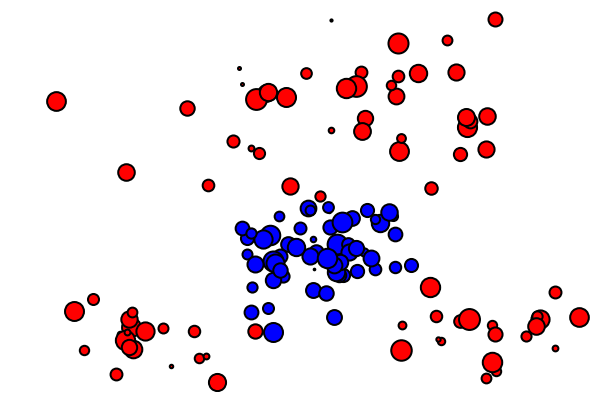

In [9]:
plt.figure(figsize = (10,7))
plt.axis("off")

for i in range(len(p0)):
    myplot(X0[0,i], X0[1,i], p0[i]*len(p0)*10, 'b')
    
for i in range(len(p1)):
    myplot(X1[0,i], X1[1,i], p1[i]*len(p1)*10, 'r')
    
plt.xlim(np.min(X1[0,:])-.1,np.max(X1[0,:])+.1)
plt.ylim(np.min(X1[1,:])-.1,np.max(X1[1,:])+.1)

plt.show()

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [10]:
C = np.transpose(np.tile(np.transpose(np.sum(X0**2,0)),(n1,1))) + np.tile(np.sum(X1**2,0),(n0,1)) - 2*np.dot(np.transpose(X0),X1)

Compute the optimal transport plan.

In [11]:
gamma = otransp(C, p0, p1)

Check that the number of non-zero entries in $\ga^\star$ is $n_0+n_1-1$.

In [12]:
print("Number of non-zero: %d (n0 + n1-1 = %d)" %(len(gamma[gamma>0]), n0 + n1-1))

Number of non-zero: 139 (n0 + n1-1 = 139)


Check that the solution satifies the constraints $\ga \in \Cc$.

In [13]:
from numpy import linalg
print("Constraints deviation (should be 0): %.2f, %.2f" %(linalg.norm(np.sum(gamma,1)-np.ravel(p0)),linalg.norm(np.transpose(np.sum(gamma, 0))-np.ravel(p1))))

Constraints deviation (should be 0): 0.00, 0.00


Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such
that $t \mapsto \mu_t$ defines a geodesic for the Wasserstein metric.


Since the $W_2$ distance is a geodesic distance, this geodesic path solves the
following variational problem

$$ \mu_t = \uargmin{\mu} (1-t)W_2(\mu_0,\mu)^2 + t W_2(\mu_1,\mu)^2. $$
This can be understood as a generalization of the usual Euclidean
barycenter to barycenter of distribution. Indeed, in the case that
$\mu_k = \de_{x_k}$, one has $\mu_t=\de_{x_t}$ where $ x_t =
(1-t)x_0+t x_1 $.


Once the optimal coupling $\ga^\star$ has been computed, the
interpolated distribution is obtained as

$$ \mu_t = \sum_{i,j} \ga^\star_{i,j} \de_{(1-t)x_{0,i} + t x_{1,j}}. $$


Find the $i,j$ with non-zero $\ga_{i,j}^\star$.

In [14]:
I,J = np.nonzero(gamma)
gammaij = gamma[I,J]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

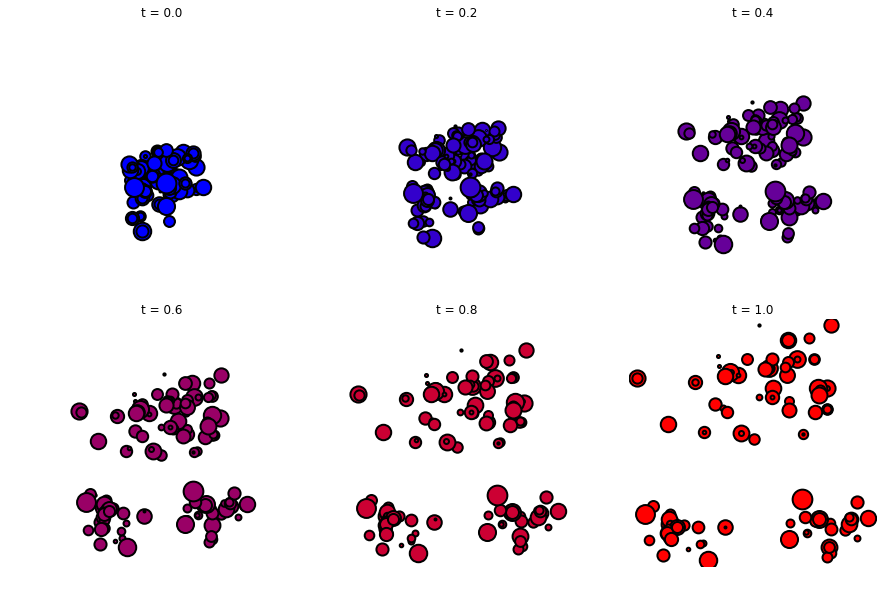

In [15]:
plt.figure(figsize =(15,10))
tlist = np.linspace(0, 1, 6)

for i in range(len(tlist)):
    t = tlist[i]
    Xt = (1-t)*X0[:,I] + t*X1[:,J]
    plt.subplot(2,3,i+1)
    plt.axis("off")
    for j in range(len(gammaij)):
        myplot(Xt[0,j],Xt[1,j],gammaij[j]*len(gammaij)*6,[t,0,1-t])
    
    plt.title("t = %.1f" %t) 
    plt.xlim(np.min(X1[0,:])-.1,np.max(X1[0,:])+.1)
    plt.ylim(np.min(X1[1,:])-.1,np.max(X1[1,:])+.1)
    
plt.show()

Optimal Assignement
-------------------
In the case where the weights $p_{0,i}=1/n, p_{1,i}=1/n$ (where $n_0=n_1=n$) are
constants, one can show that the optimal transport coupling is actually a
permutation matrix. This properties comes from the fact that
the extremal point of the polytope $\Cc$ are permutation matrices.


This means that there exists an optimal permutation $ \si^\star \in \Sigma_n $ such
that

$$ \ga^\star_{i,j} = \choice{
      1 \qifq j=\si^\star(i), \\
      0 \quad\text{otherwise}.
  } $$
  
where $\Si_n$ is the set of permutation (bijections) of
$\{1,\ldots,n\}$.


This permutation thus solves the so-called optimal assignement problem

$$ \si^\star \in \uargmin{\si \in \Sigma_n}
      \sum_{i} C_{i,\si(j)}. $$


Same number of points.

In [16]:
n0 = 40
n1 = n0

Compute points clouds.

In [17]:
X0 = random.randn(2,n0)*.3
X1 = np.hstack((gauss(int(n1/2),.5,[0,1.6]),np.hstack((gauss(int(n1/4),.3,[-1,-1]),gauss(int(n1/4),.3,[1,-1])))))

Constant distributions.

In [18]:
p0 = np.ones([n0,1])/n0
p1 = np.ones([n1,1])/n1

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [19]:
C = np.transpose(np.tile(np.transpose(np.sum(X0**2,0)),(n1,1))) + np.tile(np.sum(X1**2,0),(n0,1)) - 2*np.dot(np.transpose(X0),X1)

Display the coulds.

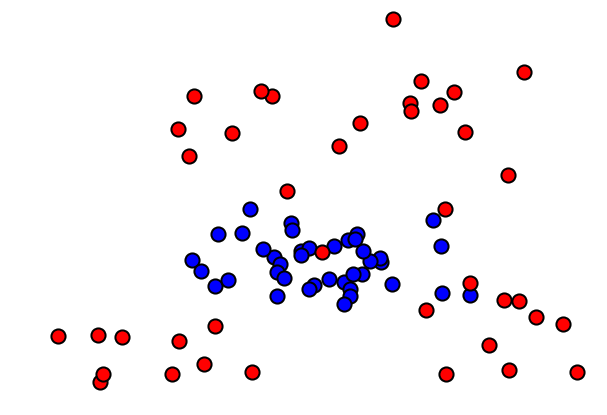

In [20]:
plt.figure(figsize = (10,7))
plt.axis('off')

myplot(X0[0,:],X0[1,:],10,'b')
myplot(X1[0,:],X1[1,:],10,'r')
    
plt.xlim(np.min(X1[0,:])-.1,np.max(X1[0,:])+.1)
plt.ylim(np.min(X1[1,:])-.1,np.max(X1[1,:])+.1)
plt.show()

Solve the optimal transport.

In [21]:
gamma = otransp(C, p0, p1)

Show that $\ga$ is a binary permutation matrix.

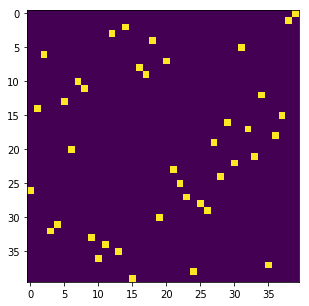

In [22]:
plt.figure(figsize = (5,5))
plt.imshow(gamma);

Display the optimal assignement.

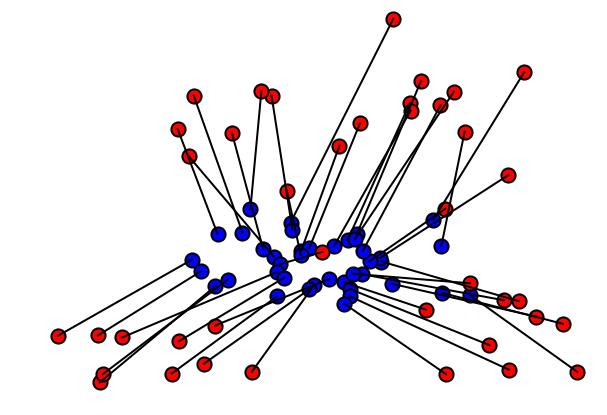

In [23]:
I,J = np.nonzero(gamma)

plt.figure(figsize = (10,7))
plt.axis('off')

for k in range(len(I)):
    h = plt.plot(np.hstack((X0[0,I[k]],X1[0,J[k]])),np.hstack(([X0[1,I[k]], X1[1,J[k]]])),'k', lw = 2)

myplot(X0[0,:], X0[1,:], 10, 'b')
myplot(X1[0,:], X1[1,:], 10, 'r')

plt.xlim(np.min(X1[0,:])-.1,np.max(X1[0,:])+.1)
plt.ylim(np.min(X1[1,:])-.1,np.max(X1[1,:])+.1)
plt.show()